In [0]:
SEQ_LEN = 1
FUTURE_PERIOD_PREDICT = 1
BATCH_SIZE = 64

import tensorflow as tf

import numpy as np
import pandas as pd
from sklearn import preprocessing
from collections import deque

from sklearn import model_selection

import random
from time import gmtime, strftime
from datetime import datetime
import itertools
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM,Activation, Dropout, BatchNormalization

import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
from google.colab import files
upload1 = files.upload()

Saving data12to17cols_energy.csv to data12to17cols_energy (1).csv


In [0]:
import io
import pandas as pd 
dt17 = pd.read_csv(io.BytesIO(upload1['data12to17cols_energy.csv']), index_col = 0)

In [33]:
pm3 = dt17.copy()
pm3.head()

,ss_all,gn_road,temp_tt,humid_tt,day,wind_tt,rainfall_tt,elec
time,,,,,,,,
1/01/2000 00:00,1,506.840989,3.3,74.0,6,2.2,0.0,23230.0
1/01/2000 01:00,1,480.024735,3.1,74.0,6,2.2,0.0,22176.0
1/01/2000 02:00,1,390.498233,3.0,75.1,6,2.2,0.0,21316.0
1/01/2000 03:00,1,321.646643,2.9,76.7,6,2.1,0.0,20636.0
1/01/2000 04:00,1,307.116608,2.5,78.6,6,2.3,0.0,20138.0


In [34]:
scaler = preprocessing.MinMaxScaler()

if 1:
    cols = ['ss_all','gn_road','temp_tt','humid_tt','day', 'wind_tt','rainfall_tt','elec']
    pm3 = pm3[cols]
    pm3 = pd.get_dummies(pm3, columns = ['day'])
    pm3['elec'] = pm3['elec']/100000
    pm3['shift_1'] = pm3['elec'].shift(24)
    pm3['shift_7'] = pm3['elec'].shift(168)
    
    pm3['gn_road'] = scaler.fit_transform(np.array(pm3['gn_road']).reshape(-1,1))

    pm3['humid_tt'] = scaler.fit_transform(np.array(pm3['humid_tt']).reshape(-1,1))
    pm3['temp_tt'] = scaler.fit_transform(np.array(pm3['temp_tt']).reshape(-1,1))

    pm3['wind_tt'] = scaler.fit_transform(np.array(pm3['wind_tt']).reshape(-1,1))
    pm3['rainfall_tt'] = scaler.fit_transform(np.array(pm3['rainfall_tt']).reshape(-1,1))    

    re_cols = ['ss_all', 'gn_road', 'temp_tt', 'humid_tt', 'wind_tt', 'rainfall_tt', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'shift_1', 'shift_7','elec' ]
    pm3 = pm3[re_cols]
    pm3.dropna(inplace = True)

print(len(pm3.columns))

16


In [35]:
# 어린이날 2017-5-5

if 1: 
    tr = pm3.loc[:'1/31/2017 00:00', :]
    val = pm3.loc['2/01/2017 01:00':'4/30/2017 00:00']
    te = pm3.loc['5/01/2017 01:00':'5/10/2017 00:00']

# 광복절 2017-8-15 
elif 0:
    tr = pm3.loc[:'5/31/2017 00:00', :]
    val = pm3.loc['6/01/2017 01:00':'8/10/2017 00:00']
    te = pm3.loc['8/11/2017 01:00':'8/20/2017 00:00']

# 성탄절 2017-12-25
elif 0:
    tr = pm3.loc[:'8/31/2017 00:00', :]
    val = pm3.loc['9/01/2017 01:00':'12/20/2017 00:00']
    te = pm3.loc['12/21/2017 01:00':'12/30/2017 00:00']
    
# 석탄일 2017-5-4
elif 0:
    tr = pm3.loc[:'1/31/2017 00:00', :]
    val = pm3.loc['2/01/2017 01:00':'4/28/2017 00:00']
    te = pm3.loc['4/29/2017 01:00':'5/08/2017 00:00']

    
'''
======================
전체 시간 모형 
======================

'''    
# 전체 시간 모형 
# 성탄절 2017-12-25


'\n======================\n전체 시간 모형 \n======================\n\n'

In [36]:
print("TRAIN: {}\nTEST: {}\nVAL: {}".format(tr.shape, te.shape, val.shape))


TRAIN: (149593, 16)
TEST: (216, 16)
VAL: (2112, 16)


In [0]:
def _deque_df(df):
    

    sequential_data = []
    prev_points = deque(maxlen = SEQ_LEN)

    for i in df.values:
        prev_points.append([n for n in i[:-1]])
        if len(prev_points) == SEQ_LEN:
            sequential_data.append([np.array(prev_points), i[-1]])

    #random.shuffle(sequential_data)

    X = []
    y = []

    for seq, target in sequential_data:
        X.append(seq)
        y.append(target)

    return np.array(X), np.array(y)



train_X, train_y = _deque_df(tr)
validation_X, validation_y = _deque_df(val)
test_X, test_y = _deque_df(te)

In [38]:
print(train_X[2])
print(train_y[2])

[[0.         0.03166413 0.20628684 0.97760224 0.90080738 0.0013624
  0.         0.         0.         0.         0.         1.
  0.         0.26952    0.21316   ]]
0.27055


In [39]:

print(f"train X shape: {train_X.shape} train y shape: {train_y.shape}")
print(f"val X shape: {validation_X.shape} val y shape: {validation_y.shape}")
print(f"test X shape: {test_X.shape} test y shape: {test_y.shape}")



train X shape: (149593, 1, 15) train y shape: (149593,)
val X shape: (2112, 1, 15) val y shape: (2112,)
test X shape: (216, 1, 15) test y shape: (216,)


In [0]:
if 1: 
    train_X = train_X.reshape(149593,15)
    validation_X = validation_X.reshape(2112,15)
    test_X = test_X.reshape(216,15)
elif 0: # 요일더미 넣었을 때 
    train_X = train_X.reshape(6233,15)
    validation_X = validation_X.reshape(87,15)
    test_X = test_X.reshape(10,15)

In [41]:
model = Sequential()
model.add(Dense(8, activation='elu', input_dim=15))
model.add(Dense(16, activation='elu', input_dim=8))
model.add(Dense(8, activation='elu', input_dim=16))
model.add(Dense(1, activation='elu'))
model.compile(optimizer='Adam',
              loss='mse',
              metrics=['accuracy'])

opt = tf.keras.optimizers.Adam(lr = 0.001, decay = 1e-6)

model.compile(loss = 'mse', optimizer = opt, metrics = ['accuracy'])

#start = datetime.now()
model.fit(train_X, train_y, batch_size = BATCH_SIZE,
                                        epochs = 10,
         validation_data = (validation_X, validation_y))



Train on 149593 samples, validate on 2112 samples
Epoch 1/10
149593/149593 [==============================] - 10s 64us/sample - loss: 0.0025 - acc: 0.0000e+00 - val_loss: 9.5957e-04 - val_acc: 0.0000e+00
Epoch 2/10
149593/149593 [==============================] - 9s 63us/sample - loss: 4.6912e-04 - acc: 0.0000e+00 - val_loss: 4.9022e-04 - val_acc: 0.0000e+00
Epoch 3/10
149593/149593 [==============================] - 10s 64us/sample - loss: 3.8904e-04 - acc: 0.0000e+00 - val_loss: 4.4258e-04 - val_acc: 0.0000e+00
Epoch 4/10
149593/149593 [==============================] - 9s 63us/sample - loss: 3.7465e-04 - acc: 0.0000e+00 - val_loss: 4.4770e-04 - val_acc: 0.0000e+00
Epoch 5/10
149593/149593 [==============================] - 9s 62us/sample - loss: 3.6884e-04 - acc: 0.0000e+00 - val_loss: 4.1067e-04 - val_acc: 0.0000e+00
Epoch 6/10
149593/149593 [==============================] - 9s 63us/sample - loss: 3.6295e-04 - acc: 0.0000e+00 - val_loss: 4.3227e-04 - val_acc: 0.0000e+00
Epoch 7/10

In [42]:
pred = model.predict(test_X)
pred = list(itertools.chain(*pred))
pred

[0.4691848,
 0.4541895,
 0.4486507,
 0.45565972,
 0.47566333,
 0.50960475,
 0.5274444,
 0.5410404,
 0.55129087,
 0.5561043,
 0.5543769,
 0.5453062,
 0.56068087,
 0.56579065,
 0.5683438,
 0.57490873,
 0.57721484,
 0.5876837,
 0.60568,
 0.6016511,
 0.58775663,
 0.5691227,
 0.5469145,
 0.5217243,
 0.50369,
 0.49389076,
 0.49115053,
 0.49419406,
 0.50277185,
 0.51733136,
 0.5281522,
 0.55206007,
 0.5636815,
 0.56757516,
 0.56711745,
 0.5498266,
 0.5666626,
 0.5748742,
 0.57559687,
 0.57819283,
 0.572215,
 0.5718068,
 0.590092,
 0.59222573,
 0.5845972,
 0.5745962,
 0.5707238,
 0.49855122,
 0.47749817,
 0.46770015,
 0.46489504,
 0.47008505,
 0.48279074,
 0.50704366,
 0.5328089,
 0.56566954,
 0.5738505,
 0.57425874,
 0.5702725,
 0.54530597,
 0.56992334,
 0.58127975,
 0.58230793,
 0.5867951,
 0.5784915,
 0.576619,
 0.58732283,
 0.5840557,
 0.5715103,
 0.56036663,
 0.5531612,
 0.5154072,
 0.49639317,
 0.48694438,
 0.48198548,
 0.48579556,
 0.49322316,
 0.5062868,
 0.51362085,
 0.5367554,
 0.551

In [18]:
yhat = model.predict(test_X)
yhat

array([[0.6805387 ],
       [0.6661951 ],
       [0.66219825],
       [0.66553205],
       [0.6802158 ],
       [0.7091643 ],
       [0.754373  ],
       [0.8183986 ],
       [0.83743757],
       [0.8342591 ],
       [0.82438636],
       [0.77469873],
       [0.79864734],
       [0.80934703],
       [0.8119295 ],
       [0.820741  ],
       [0.8124295 ],
       [0.7919406 ],
       [0.7709089 ],
       [0.7491564 ],
       [0.72896177],
       [0.72335964],
       [0.73573947],
       [0.68928224],
       [0.6629037 ],
       [0.6480642 ],
       [0.64189   ],
       [0.6465016 ],
       [0.66065013],
       [0.69126046],
       [0.73387355],
       [0.7983552 ],
       [0.824564  ],
       [0.8211148 ],
       [0.80555135],
       [0.7530818 ],
       [0.7706484 ],
       [0.77638555],
       [0.7786284 ],
       [0.7873618 ],
       [0.7864877 ],
       [0.77183187],
       [0.7550485 ],
       [0.73522276],
       [0.71409154],
       [0.7087066 ],
       [0.7204981 ],
       [0.627

In [0]:
result = pd.DataFrame({'y_true':test_y,'y_pred':pred})

In [0]:
import matplotlib.pyplot as plt

In [0]:
total_mape = np.mean(np.abs(test_y-pred)/test_y)*100

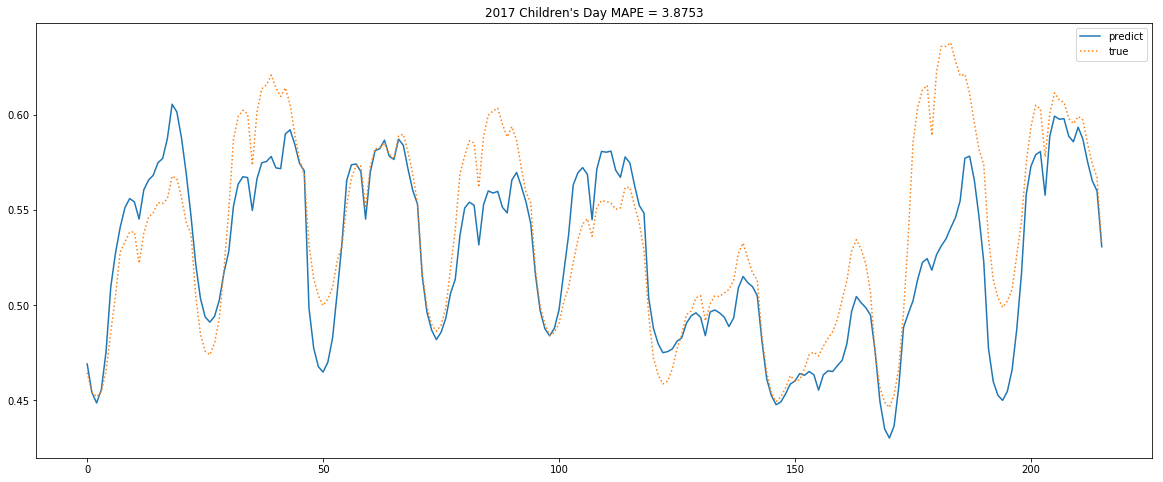

In [46]:
plt.figure(figsize=(20,8))
#plt.title("Childeren's Day from time01-21st to time23-30th Dec, MAPE= {}".format(mape.round(4)))
plt.title("2017 Children's Day MAPE = {}".format(total_mape.round(4)))
plt.plot(pred, label='predict')
plt.plot(test_y, label='true', linestyle = ':')
plt.legend()
plt.show()


In [28]:

total_mape

3.37818766227233